# Importing Libraries

In [3]:
# !pip install mahotas
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os
import mahotas
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt


# Canny edge detection

In [4]:
def canny_grey_image(image):
  gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
  return gray_image

In [5]:
def canny_edges(gray_image):
    edges = cv2.Canny(gray_image, 50, 150)
    return edges

# Computing color histograms

In [6]:
def get_color_blue(original_image):
  hist_b = cv2.calcHist([original_image], [0], None, [256], [0, 256]).flatten().astype(int)
  return hist_b

In [7]:
def get_color_green(original_image):
  hist_g = cv2.calcHist([original_image], [1], None, [256], [0, 256]).flatten().astype(int)
  return hist_g

In [8]:
def get_color_red(original_image):
  hist_r = cv2.calcHist([original_image], [2], None, [256], [0, 256]).flatten().astype(int)
  return hist_r

# GLCM features

In [9]:
def glcm(gray_image):
  textures = mahotas.features.haralick(gray_image)
  mean_texture = textures.mean(axis=0)
  return mean_texture

In [10]:
image_count = {}
default_image_size = tuple((128, 128))  # Reduced image size

data = []

for root, _, files in os.walk('/kaggle/input/plantdisease/PlantVillage'):
    disease = os.path.basename(root)
    image_count[disease] = 0

    # Include images based on the starting word of the disease
    if disease.lower().startswith(('pepper')):
        print(disease)
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png') or file.endswith('.JPG') or file.endswith('.PNG') or file.endswith('JPEG') or file.endswith('jpeg'):
                image_path = os.path.join(root, file)

                if image_count[disease] >= 1000:
                    continue

                # Read the original image and resize
                original_image = cv2.imread(image_path)
                original_image = cv2.resize(original_image, default_image_size)

                # Perform Canny edge detection
                gray_image = canny_grey_image(original_image)
                edges = canny_edges(gray_image)

                # Compute color histograms (RGB) for each channel
                hist_b = get_color_blue(original_image)
                hist_g = get_color_green(original_image)
                hist_r = get_color_red(original_image)

                # Compute GLCM texture features
                mean_texture = glcm(gray_image)

                # Compute shape features using Hu Moments
                moments = cv2.HuMoments(cv2.moments(gray_image)).flatten()

                # Flatten the images and histograms to 1D arrays and convert to NumPy array
                flattened_original_image = original_image.flatten().astype(int)
                flattened_edges = edges.flatten().astype(int)
                flattened_hist_b = hist_b.astype(int)
                flattened_hist_g = hist_g.astype(int)
                flattened_hist_r = hist_r.astype(int)
                flattened_texture = mean_texture.astype(int)
                flattened_moments = moments.astype(int)

                # Concatenate the flattened pixel values, histograms, texture, moments, and disease name in data
                combined_features = np.concatenate([flattened_original_image, flattened_edges, flattened_hist_b, flattened_hist_g, flattened_hist_r, flattened_texture, flattened_moments])
                data.append([combined_features, disease])

                # Increment the counter for the current disease
                image_count[disease] += 1


df = pd.DataFrame(data, columns=['image_pixels', 'disease'])

# Split the data into training and testing sets
X = np.vstack(df['image_pixels'].to_numpy())
y = df['disease']

# Encode disease labels using LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Test-train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model (using RandomForest as an example)
# model = RandomForestClassifier(random_state=42)




Pepper__bell___Bacterial_spot
Pepper__bell___healthy


# K-Nearest Neighbours

In [11]:
# from sklearn.neighbors import KNeighborsClassifier

# model = KNeighborsClassifier(n_neighbors=5)  # Adjust the number of neighbors as needed
# model.fit(X_train, y_train)

# # Make predictions
# y_pred = model.predict(X_test)


# Decision Trees

In [12]:
# from sklearn.tree import DecisionTreeClassifier

# model = DecisionTreeClassifier(random_state=42)
# model.fit(X_train, y_train)

# # Make predictions
# y_pred = model.predict(X_test)


# Random forests

In [13]:
# model = RandomForestClassifier(n_estimators=100,random_state=42)
# model.fit(X_train, y_train)

# # Make predictions
# y_pred = model.predict(X_test)


# Grid-Search for Random Forests

In [14]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define the parameter grid for Grid Search
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Create a RandomForestClassifier
# rf = RandomForestClassifier(random_state=42)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Print the best parameters found by Grid Search
# print("Best Parameters:", grid_search.best_params_)

# # Get the best model
# best_rf = grid_search.best_estimator_
# y_pred = best_rf.predict(X_test)


# XG Boost

In [15]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)


# RandomizedSearch for XG-Boost

In [16]:
# param_dist = {
#     'max_depth': [3, 5, 7, 10, None],
#     'learning_rate': [0.01, 0.1, 0.2, 0.3],
#     'n_estimators': [50, 100, 200, 300],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
#     'gamma': [0, 1, 2],
#     'min_child_weight': [1, 2, 3]
# }

# # Create an XGBClassifier
# xgb_model = xgb.XGBClassifier(random_state=42)

# # Initialize RandomizedSearchCV
# random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=10, scoring='accuracy', cv=3, n_jobs=-1, random_state=42)

# # Fit the random search to the data
# random_search.fit(X_train, y_train)

# # Print the best parameters found by RandomizedSearchCV
# print("Best Parameters:", random_search.best_params_)

# # Get the best model
# best_xgb = random_search.best_estimator_

# # Make predictions on the test set
# y_pred = best_xgb.predict(X_test)

In [17]:
# import xgboost as xgb
# # Now you can use XGBoost with the binary labels
# model = xgb.XGBClassifier()
# model.fit(X_train, y_train)

In [18]:
# y_pred = model.predict(X_test)



In [19]:
len(X_train[0])

66324

In [20]:
print(image_count)

{'PlantVillage': 0, 'Pepper__bell___Bacterial_spot': 997, 'Potato___healthy': 0, 'Tomato_Leaf_Mold': 0, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 0, 'Tomato_Bacterial_spot': 0, 'Tomato_Septoria_leaf_spot': 0, 'Tomato_healthy': 0, 'Tomato_Spider_mites_Two_spotted_spider_mite': 0, 'Tomato_Early_blight': 0, 'Tomato__Target_Spot': 0, 'Pepper__bell___healthy': 1000, 'Potato___Late_blight': 0, 'Tomato_Late_blight': 0, 'Potato___Early_blight': 0, 'Tomato__Tomato_mosaic_virus': 0}


# Model evaluation using accuray, f1 score and confusion matrix

In [21]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.945


In [22]:
f1 = f1_score(y_test, y_pred, average='weighted')
f1

0.9450082574316885

In [23]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[195,  12],
       [ 10, 183]])

In [24]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.94
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95       207
           1       0.94      0.95      0.94       193

    accuracy                           0.94       400
   macro avg       0.94      0.95      0.94       400
weighted avg       0.95      0.94      0.95       400

Confusion Matrix:
 [[195  12]
 [ 10 183]]


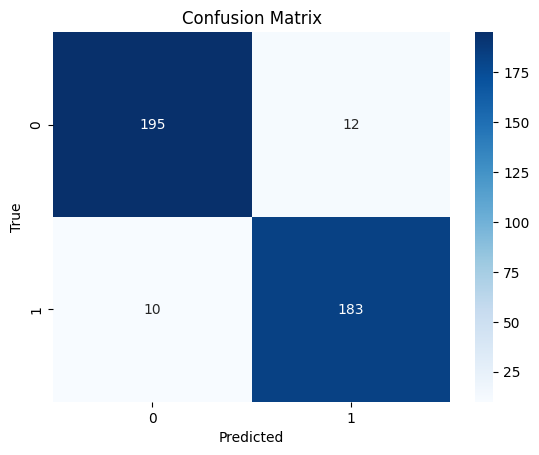

In [25]:
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()